# BI-PRS - Semestral Work 1
### Country selection according to the representant's data

In [1]:
K <- 27
L <- nchar('bardatskii')
M <- ((K + L) * 47) %% 11 + 1

cat('Parameter M =', M, '=> Norsko, K.Dedecius')

Parameter M = 2 => Norsko, K.Dedecius

### Neccessary imports

In [2]:
library(cowplot)
library(eurostat)
library(ggplot2)
library(gridExtra)
library(repr)
library(tibble)
library(tidyr)
library(vtable)

Loading required package: kableExtra



## Dataset preparation

- Download the dataset
- Describe the columns
- Extract relevant data

In [3]:
# Downloading the dataset
dataset <- get_eurostat(id='crim_gen_reg')

Table crim_gen_reg cached at /tmp/Rtmp6MvqQS/eurostat/9ac864b516df52315ea084dcece6e0fc.rds



In [4]:
# First glance at the data we've received
head(dataset, 2)

freq,unit,iccs,geo,TIME_PERIOD,values
<chr>,<chr>,<chr>,<chr>,<date>,<dbl>
A,NR,ICCS0101,AL,2008-01-01,88
A,NR,ICCS0101,AL,2009-01-01,82


#### Column description:

- **freq**: Frequency
- **unit**: Unit of measure
- **iccs**: International classification of crime for statistical purposes
- **geo**: Geopolitical entity (reporting)
- **TIME_PERIOD**: Time
 
[1]

#### Dataset completeness

There are no problems with the completeness of the data for the year $2021$ from Norway.

![completeness](src/images/completeness.png)
[2]

#### Data units of measure explanation

We have multiple units of measure in this dataset. Let's clarify which ones we have here.

![units](src/images/units.png)
[3]

#### Relevant data selection and dataset transformations
- Norway NUTS3 regions
- Records for the year $2021$
- Make separate columns for relative and absolute values
- Make columns iccs and geo factors

In [5]:
# Relative data selection
data <- subset(dataset, 
               startsWith(geo, 'NO') &
               nchar(geo) == 5 &
               TIME_PERIOD == '2021-01-01', 
               c(unit, iccs, geo, values))

#### Rename factor categories
![iccs_codes](src/images/iccs_codes.png)

[4] 

**Not provided in the dataset**:
- Assault (ICCS02011)
- Burglary (ICCS0501)
- Burglary of private residential premises (ICCS05012)

[2]

In [6]:
prev_labels <- c('ICCS0101', 'ICCS0401', 'ICCS0502', 'ICCS050211')
new_labels <- c('Int. homicide', 'Robbery', 'Other theft', 'Vehicle theft')
data$iccs <- factor(data$iccs, levels=prev_labels, labels=new_labels)

In [7]:
# Dataset transformation
data_by_unit <- split(data[, -1], data$unit)
all.equal(data_by_unit$P_HTHAB[, 1:2], data_by_unit$NR[, 1:2])

[1] TRUE

In [8]:
data <- merge(x=data_by_unit$P_HTHAB, y=data_by_unit$NR, by=c('iccs', 'geo'), all=T)  # outer join
colnames(data)[3] <- 'rel'
colnames(data)[4] <- 'abs'

In [9]:
any(is.na(data))  # no NA values

[1] FALSE

In [10]:
head(data, 5)

,iccs,geo,rel,abs
,<fct>,<chr>,<dbl>,<dbl>
1,Int. homicide,NO020,0.00,0
2,Int. homicide,NO060,0.21,1
3,Int. homicide,NO071,0.00,0
4,Int. homicide,NO074,0.00,0
5,Int. homicide,NO081,1.00,7


In addition to the data processing performed, it is important to note that the values of ICCS050211 are already contained in ICCS0502. We will resolve this from below depending on what the specific test requires.
[6]

## Exploratory data analysis & descriptive statistics

The data we have represent a number of crimes of each specific type for each NUTS3 Norway region represented in P_HTHAB (Per hundred thousand inhabitants) units. To analyse the following data, statistical measures and graphs will be used. As a result, we want to get insights about the criminality in different NUTS3 regions of Norway.

In [11]:
freq_df <- pivot_wider(data[, -4], names_from=iccs, values_from=rel)
freq_df[, 'Other theft'] <- freq_df[, 'Other theft'] - freq_df[, 'Vehicle theft']
freq_table <- (freq_df %>% column_to_rownames('geo') %>% as.matrix() %>% as.table())
names(dimnames(freq_table)) <- c('geo', 'iccs')
prob_table.row_cond <- prop.table(freq_table, margin=1)
prob_table.col_cond <- prop.table(freq_table, margin=2)

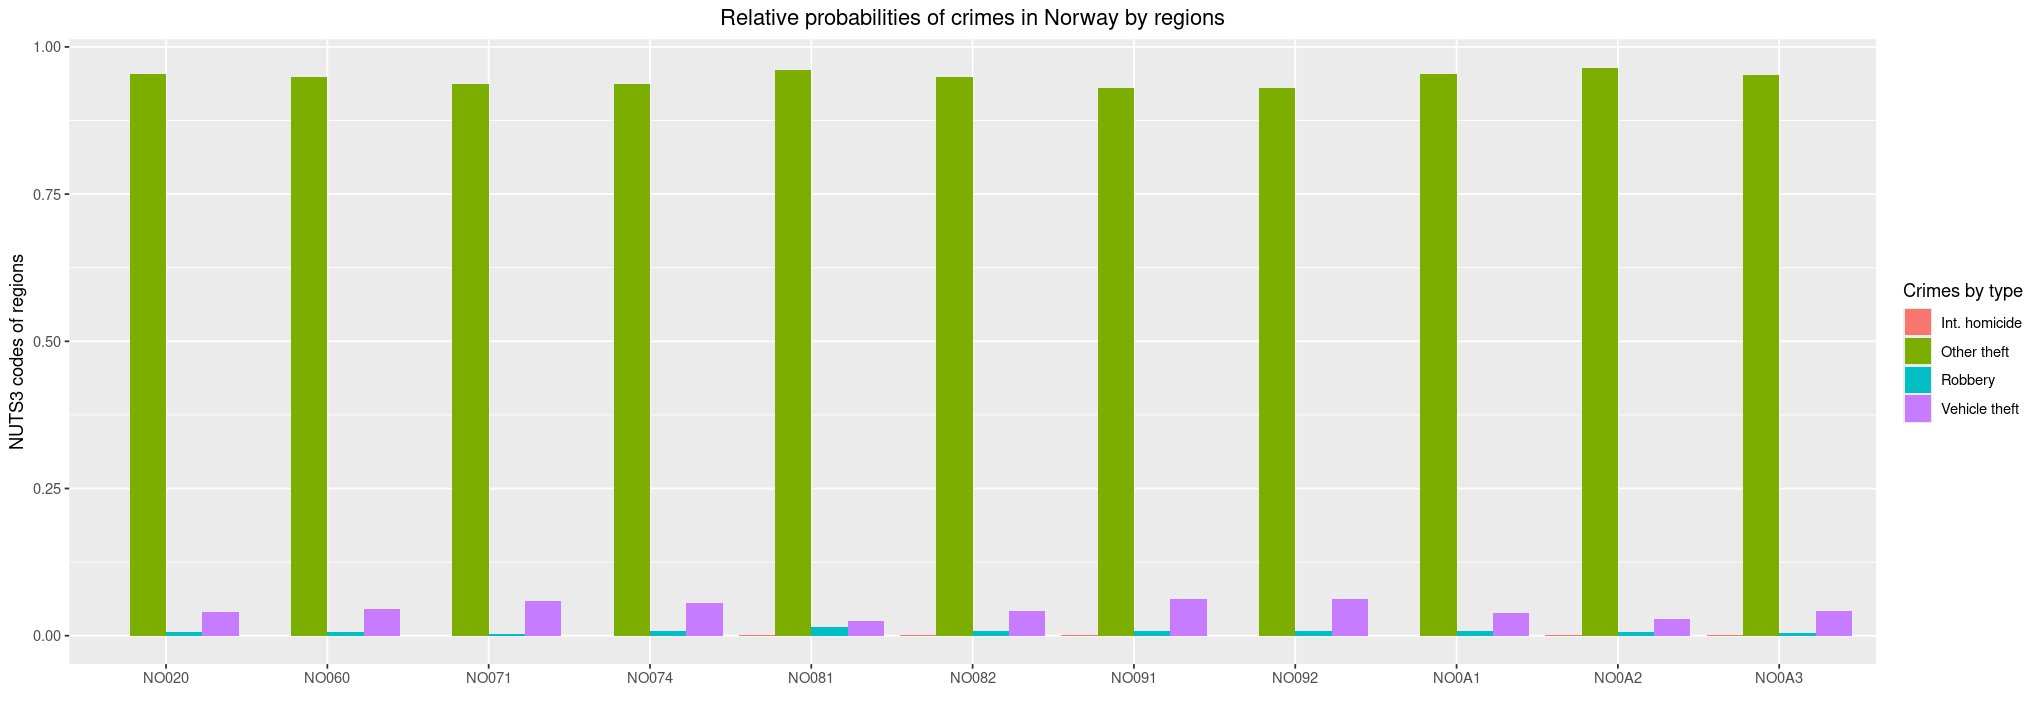

In [12]:
options(repr.plot.width=17, repr.plot.height=6) # Regulates the size of a plot [5]
ggplot(as.data.frame(prob_table.row_cond), aes(x=geo, y=Freq, fill=iccs)) +
    geom_bar(stat='identity', position='dodge') +
    labs( title='Relative probabilities of crimes in Norway by regions', x='', y='NUTS3 codes of regions', # Changes a title & axes of a plot
         fill="Crimes by type" ) + # Changes a title of a legend
    theme(plot.title = element_text(hjust=0.5)) # Centers a title of a plot

What we see from the plot upwards is that **without taking into account the criminality** of a particular NUTS3 region in Norway,
the **distribution of crimes by types** in all regions is **very similar**. That gives us an intuition (tests weren't conducted yet) that
**all crime types** are similarly distributed **in all regions.** We can see that **theft is the most likely-to-happen crime in all regions and an int. homicide is the most rare crime**.

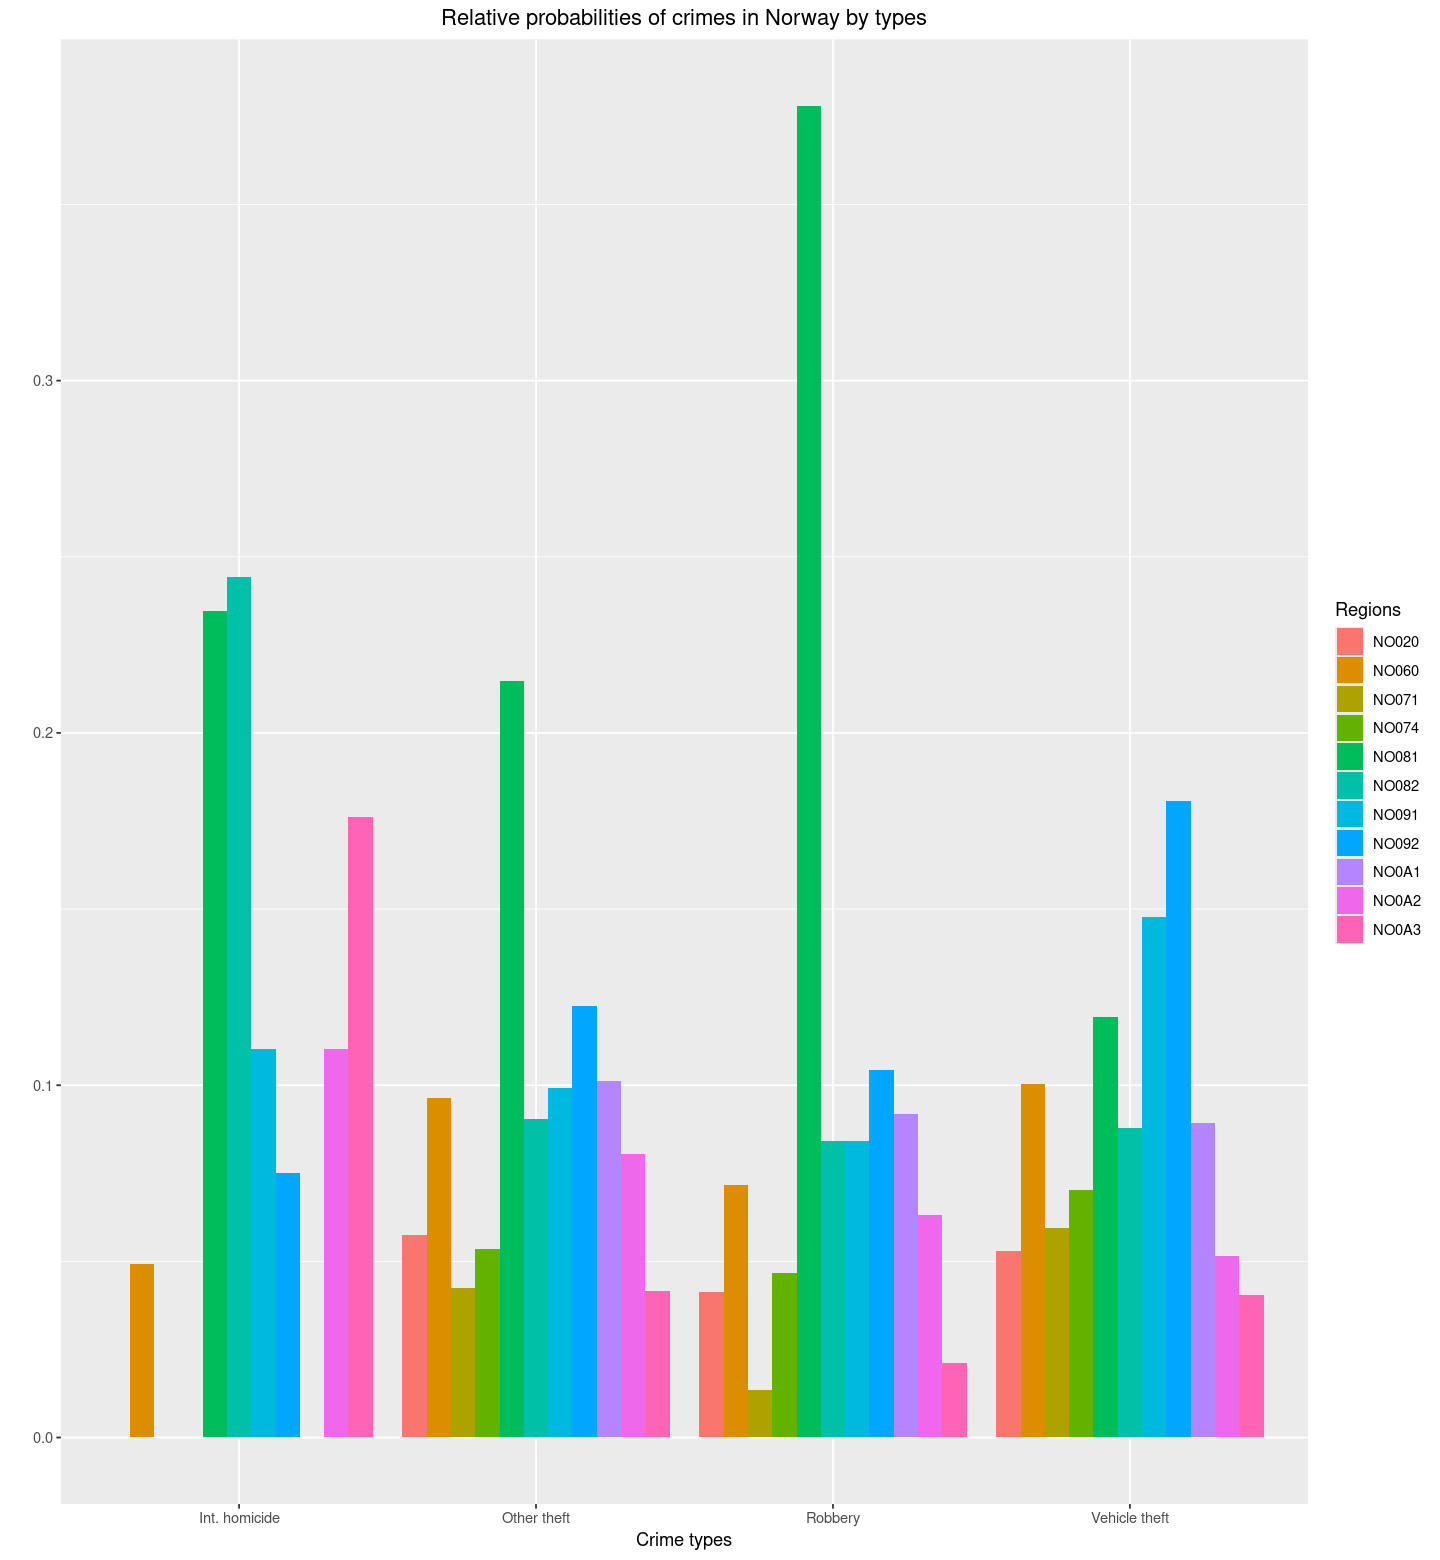

In [13]:
options(repr.plot.width=12, repr.plot.height=13) # Regulates the size of a plot [5]
ggplot(as.data.frame(prob_table.col_cond), aes(x=iccs, y=Freq, fill=geo)) +
    geom_bar(stat='identity', position='dodge') +
    labs( title='Relative probabilities of crimes in Norway by types', y='', x = 'Crime types', # Changes a title & axes of a plot
         fill="Regions" ) + # Changes a title of a legend
    theme(plot.title=element_text(hjust=0.5)) # Centers a title of a plot

This plot depicts a **distribution of probability** of crimes by types in regions of Norway. Looking at the probabilities of each crime happening in a specific region, we can highlight these facts which immediately catch the eye:

- **A robbery, a theft** is most likely to happen in **NO081**
- **An int. homicide** is most likely to happen in **NO082**
- **A theft of a vehicle** is most likely to happen in **NO092**

\* all statements are related to the year of $2021$

## Contingency table

### Visual analysis of tables

Let's create contingency table - matrix of probabilities or frequencies - to see joined distribution or joint frequencies of two random variables across each category of each variable.

Now we will create contingency table across **iccs** and **geo** variables using absolute number of crime cases. But later we will use relative values, because they represent rate of particular crime taking also in consideration population size.

In [14]:
ct_abs <- xtabs(formula = abs ~ iccs + geo, data=data)
ct_abs

               geo
iccs            NO020 NO060 NO071 NO074 NO081 NO082 NO091 NO092 NO0A1 NO0A2
  Int. homicide     0     1     0     0     7    13     2     1     0     3
  Robbery          19    42     4    14   327   131    44    40    55    50
  Other theft    3046  6515  1491  1878 21030 16214  6125  5538  6973  7256
  Vehicle theft   122   294    89   106   518   684   388   347   268   205
               geo
iccs            NO0A3
  Int. homicide     2
  Robbery           7
  Other theft    1580
  Vehicle theft    67

In each cell we can observe absolute number of crime cases of particular crime type in particular NUTS3 region in year $2021$.

In our data we have one problem - Theft crime type contains also all thefts of vehicle, because theft of vehicle is a subtype. Therefore, we will subtract surplus thefts from Theft type.


In [15]:
ct_abs['Other theft',] <- ct_abs['Other theft',] - ct_abs['Vehicle theft',]

In [16]:
ct_abs

               geo
iccs            NO020 NO060 NO071 NO074 NO081 NO082 NO091 NO092 NO0A1 NO0A2
  Int. homicide     0     1     0     0     7    13     2     1     0     3
  Robbery          19    42     4    14   327   131    44    40    55    50
  Other theft    2924  6221  1402  1772 20512 15530  5737  5191  6705  7051
  Vehicle theft   122   294    89   106   518   684   388   347   268   205
               geo
iccs            NO0A3
  Int. homicide     2
  Robbery           7
  Other theft    1513
  Vehicle theft    67

We will add margins to see also total crime cases for each crime type and for each region.

In [17]:
addmargins(ct_abs)

,NO020,NO060,NO071,NO074,NO081,NO082,NO091,NO092,NO0A1,NO0A2,NO0A3,Sum
Int. homicide,0,1,0,0,7,13,2,1,0,3,2,29
Robbery,19,42,4,14,327,131,44,40,55,50,7,733
Other theft,2924,6221,1402,1772,20512,15530,5737,5191,6705,7051,1513,74558
Vehicle theft,122,294,89,106,518,684,388,347,268,205,67,3088
Sum,3065,6558,1495,1892,21364,16358,6171,5579,7028,7309,1589,78408


For example, we can observe, that in total there were $78408$ crime cases for all given crime types across all regions for year $2021$, most of them - $74558$ were thefts. The biggest number of thefts were in NO081 (Oslo, capital city of Norway) - $20512$ cases.

Let's now create contingency table with empirical probabilities:

In [18]:
round(addmargins(prop.table(ct_abs)), digits=5)  # TODO: comments below

,NO020,NO060,NO071,NO074,NO081,NO082,NO091,NO092,NO0A1,NO0A2,NO0A3,Sum
Int. homicide,0.00000,0.00001,0.00000,0.00000,0.00009,0.00017,0.00003,0.00001,0.00000,0.00004,0.00003,0.00037
Robbery,0.00024,0.00054,0.00005,0.00018,0.00417,0.00167,0.00056,0.00051,0.00070,0.00064,0.00009,0.00935
Other theft,0.03729,0.07934,0.01788,0.02260,0.26161,0.19807,0.07317,0.06620,0.08551,0.08993,0.01930,0.95090
Vehicle theft,0.00156,0.00375,0.00114,0.00135,0.00661,0.00872,0.00495,0.00443,0.00342,0.00261,0.00085,0.03938
Sum,0.03909,0.08364,0.01907,0.02413,0.27247,0.20863,0.07870,0.07115,0.08963,0.09322,0.02027,1.00000


It is much better now to analyze data. We chose $5$ digits, because for this precision at least not all probabilities for Intentional homicide are $0$, and it is still readable.

Each cell represents empirical probability $P(Crime\ type, Region)$, except margins, which represent empirical probability $P(Crime\ type)$ or $P(Region)$.

We can observe, that the most criminal region is NO081 (Oslo) with probability $\approx 0.272$ of crime occurrence in this region.

Now we can see the main problem of absolute values - it makes sense that in Oslo, which has very high population, there will be the highest probability of theft. Therefore, we will now create contingency tables for relative values and will use them for further analysis.

In [19]:
ct_rel <- xtabs(formula=rel ~ iccs + geo, data=data)
ct_rel['Other theft',] <- ct_rel['Other theft',] - ct_rel['Vehicle theft',]
addmargins(ct_rel)

,NO020,NO060,NO071,NO074,NO081,NO082,NO091,NO092,NO0A1,NO0A2,NO0A3,Sum
Int. homicide,0.00,0.21,0.00,0.00,1.00,1.04,0.47,0.32,0.00,0.47,0.75,4.26
Robbery,5.13,8.91,1.66,5.78,46.91,10.46,10.43,12.95,11.40,7.83,2.64,124.10
Other theft,788.98,1320.46,583.33,731.72,2942.85,1240.03,1359.86,1680.79,1389.22,1103.75,569.77,13710.76
Vehicle theft,32.92,62.40,37.03,43.77,74.32,54.62,91.97,112.35,55.53,32.09,25.23,622.23
Sum,827.03,1391.98,622.02,781.27,3065.08,1306.15,1462.73,1806.41,1456.15,1144.14,598.39,14461.35


From dataset description, we know that relative values represent the rate by $100,000$ population size. This means that the absolute cases number should be divided by factor of 100,000 for whole population size in the region. For population size $420,000$ the factor will be $4.2$.

This means that relative values take into consideration the population size.

In [20]:
round(addmargins(proportions(ct_rel)), digits=5)

,NO020,NO060,NO071,NO074,NO081,NO082,NO091,NO092,NO0A1,NO0A2,NO0A3,Sum
Int. homicide,0.00000,0.00001,0.00000,0.00000,0.00007,0.00007,0.00003,0.00002,0.00000,0.00003,0.00005,0.00029
Robbery,0.00035,0.00062,0.00011,0.00040,0.00324,0.00072,0.00072,0.00090,0.00079,0.00054,0.00018,0.00858
Other theft,0.05456,0.09131,0.04034,0.05060,0.20350,0.08575,0.09403,0.11623,0.09606,0.07632,0.03940,0.94810
Vehicle theft,0.00228,0.00431,0.00256,0.00303,0.00514,0.00378,0.00636,0.00777,0.00384,0.00222,0.00174,0.04303
Sum,0.05719,0.09626,0.04301,0.05402,0.21195,0.09032,0.10115,0.12491,0.10069,0.07912,0.04138,1.00000


Again, we see that $P(Region = \text{NO081}) \approx 0.212$ - still Oslo has the highest probability of for some crime to occur.

Analyzing further probabilities, we can observe interesting details:
- NO081 (Oslo) has the highest crime probability $(\approx 0.212)$ and rate $(3065.08)$.
- NO0A3 (Møre og Romsdal) has the least crime probability $(\approx 0.041)$ and rate $(598.39)$, just a little bit ahead from NO071 (Nordland) with prob. $\approx 0.043$ and rate $=	622.02$.
- Theft is the most frequent crime (prob. $\approx 0.95$ and rate $= 13710.76$).
- Intentional homicide is the least frequent crime (prob. $\approx 0.0003$ and rate $= 4.26$).

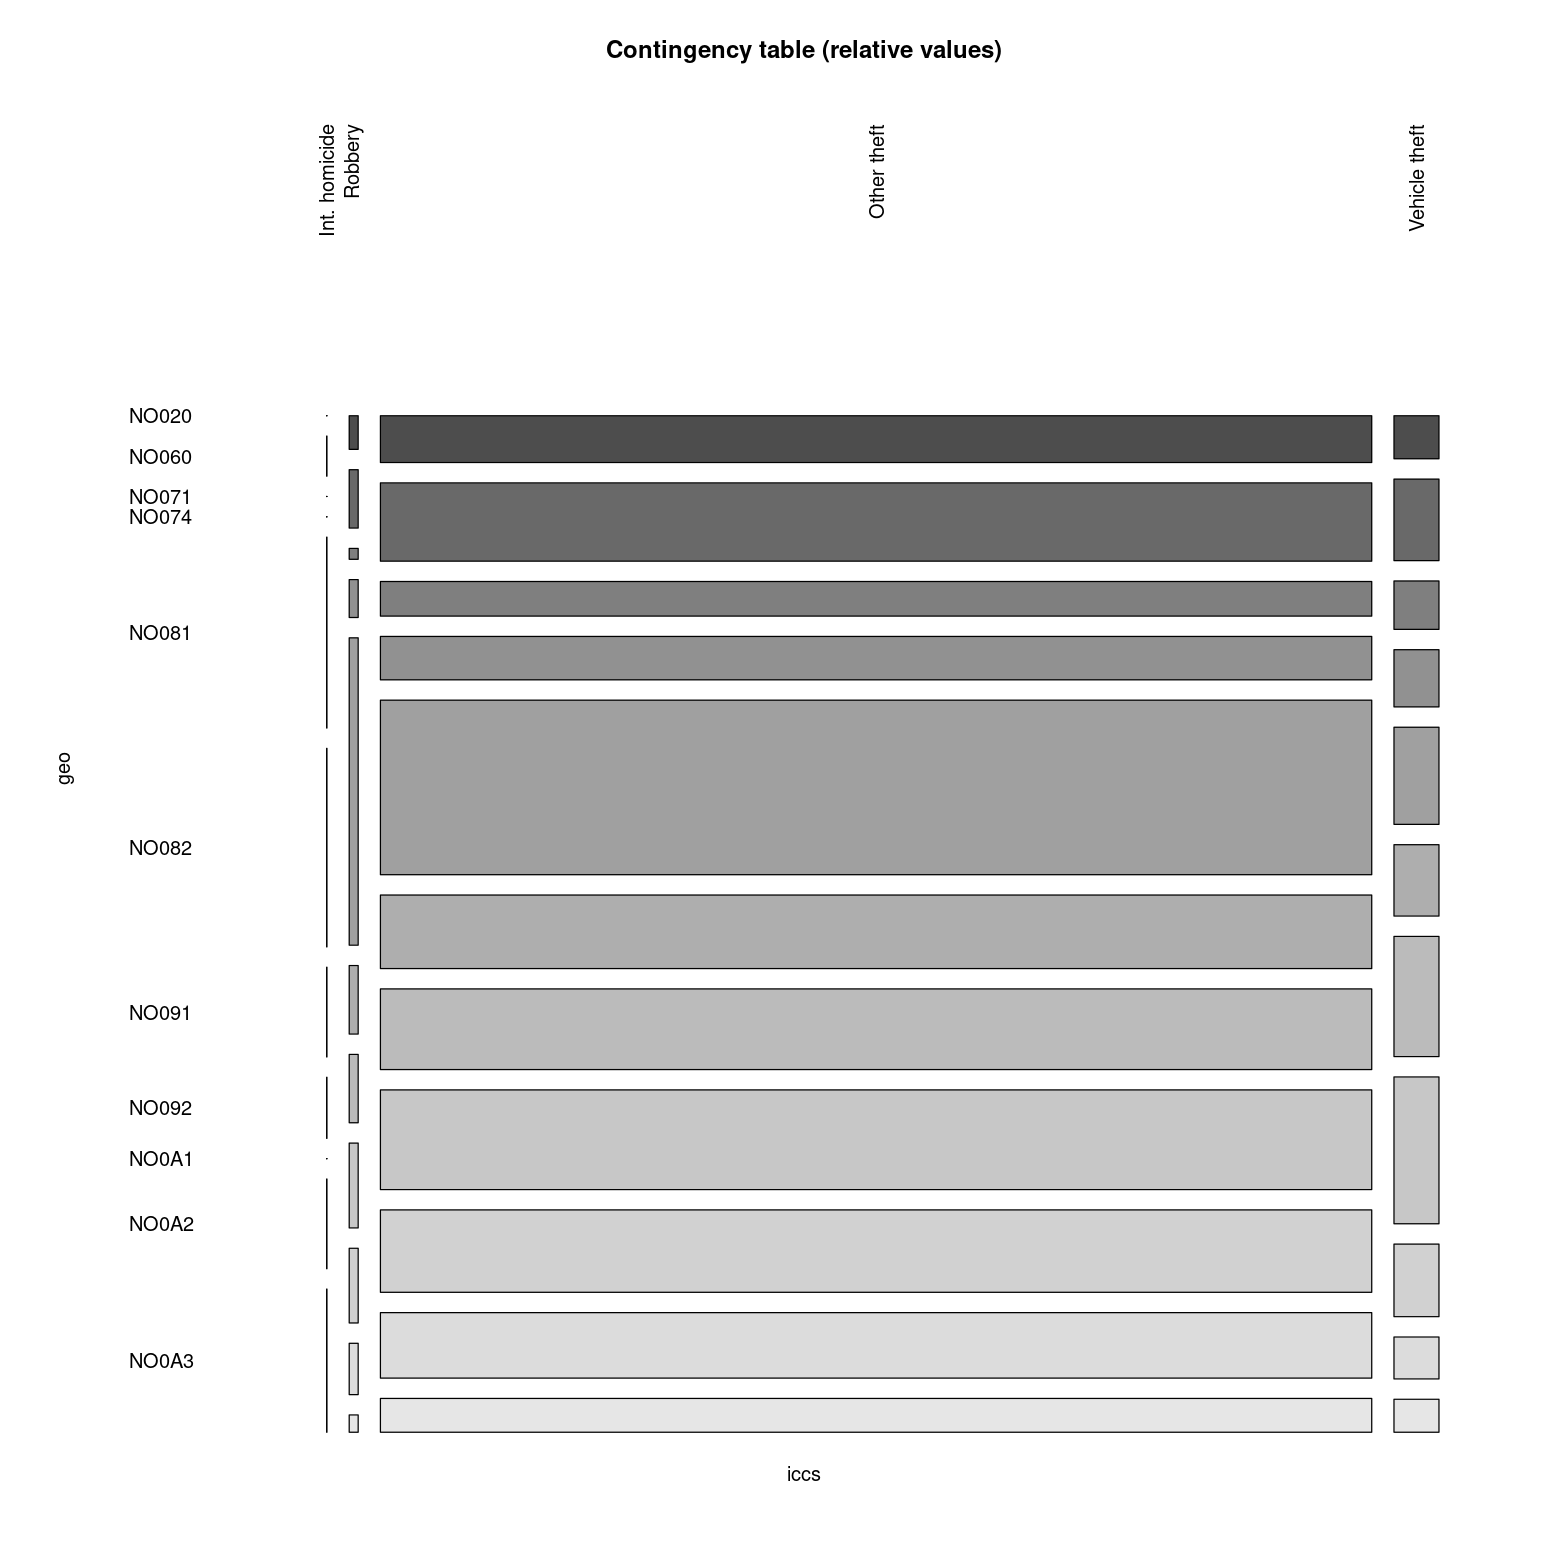

In [21]:
options(repr.plot.width=13, repr.plot.height=13) # Regulates the size of a plot
mosaicplot(ct_rel, color=T, main='Contingency table (relative values)', las=2, cex=1)

On the plot we can observe more visually the empirical joint distribution. Along $x$-axis we have crime types, starting with intentional homicide, then robbery and then the rest.

### Hypotheses for tables

Now lets accomplish test of independence - what we want to test is whether random variables **iccs** and **geo** are independent.

For this let's use Pearson's $\chi^2$ test:

- $H_0$: $p_{ij} = p_{i\cdot} p_{\cdot j}, \qquad i=1,\ldots,r; j=1,\ldots, c$
- $H_A$: the $H_0$ does not hold


In [22]:
out <- chisq.test(ct_rel)
out

Warning message in chisq.test(ct_rel):
“Chi-squared approximation may be incorrect”



	Pearson's Chi-squared test

data:  ct_rel
X-squared = 97.257, df = 30, p-value = 5.009e-09


In [23]:
addmargins(out$observed)

,NO020,NO060,NO071,NO074,NO081,NO082,NO091,NO092,NO0A1,NO0A2,NO0A3,Sum
Int. homicide,0.00,0.21,0.00,0.00,1.00,1.04,0.47,0.32,0.00,0.47,0.75,4.26
Robbery,5.13,8.91,1.66,5.78,46.91,10.46,10.43,12.95,11.40,7.83,2.64,124.10
Other theft,788.98,1320.46,583.33,731.72,2942.85,1240.03,1359.86,1680.79,1389.22,1103.75,569.77,13710.76
Vehicle theft,32.92,62.40,37.03,43.77,74.32,54.62,91.97,112.35,55.53,32.09,25.23,622.23
Sum,827.03,1391.98,622.02,781.27,3065.08,1306.15,1462.73,1806.41,1456.15,1144.14,598.39,14461.35


In [24]:
round((addmargins(out$expected)), digits=3)

,NO020,NO060,NO071,NO074,NO081,NO082,NO091,NO092,NO0A1,NO0A2,NO0A3,Sum
Int. homicide,0.244,0.410,0.183,0.230,0.903,0.385,0.431,0.532,0.429,0.337,0.176,4.26
Robbery,7.097,11.945,5.338,6.704,26.303,11.209,12.552,15.502,12.496,9.818,5.135,124.10
Other theft,784.105,1319.732,589.735,740.720,2905.993,1238.357,1386.810,1712.652,1380.571,1084.755,567.332,13710.76
Vehicle theft,35.585,59.893,26.764,33.616,131.882,56.200,62.937,77.725,62.654,49.229,25.747,622.23
Sum,827.030,1391.980,622.020,781.270,3065.080,1306.150,1462.730,1806.410,1456.150,1144.140,598.390,14461.35


From expected frequencies we can observe, that not all cells have values $\geq 5$, for example $n_{11} = 0.244 \lt 5 $. This is an important premise to use the Pearson $\chi^2$ test, even when running the test we had a warning that approximation of the test may be incorrect (though it does not implicate that the problem is with the premise).

Also, in table not all values are integers, this test would work better with absolute values, but in this situation we won't take into consideration population density.

Now let's test homogeneity of multinomial distributions:
- $H_0$: row probabilities $p_{i1}, \ldots, p_{i\cdot}$ are not dependent on $i$
- $H_A$: $H_0$ does not hold

For this test we already have test statistics:$$\chi^2 = n \sum_{i=1}^r \sum_{j=1}^c \frac{n_{ij}^2}{n_{i\cdot} n_{\cdot j}} -n = 97.257.$$

If $\chi^2 \geq \chi_{(r-1)(c-1)}^2(\alpha)$, $H_0$ is rejected.

In [25]:
alpha <- 0.05
rows <- nrow(ct_rel)
cols <- ncol(ct_rel)

df <- (rows - 1) * (cols - 1)

critical_value <- qchisq(1 - alpha, df)
round(critical_value, digits=3)

[1] 43.773

We see that:  $\chi^2 = 97.257 \geq  43.773 = \chi_{(r-1)(c-1)}^2(\alpha)$.
So the $H_0$ is rejected in preference of the alternative $H_A$, that row distributions are dependent are on crime type - in other words - distributions of each crime type across every region are not the same, distribution of Theft crime type across all regions is not the same as distribution of Intentional homicide across all regions.

To test independence of the random variables we will use the Fisher exact test:

- $H_0$: $p_{ij} = p_{i\cdot} p_{\cdot j}, \qquad i=1,\ldots,r; j=1,\ldots, c$
- $H_A$: the $H_0$ does not hold

In [26]:
fisher.test(ct_rel, simulate.p.value=T)

Warning message in fisher.test(ct_rel, simulate.p.value = T):
“'x' has been rounded to integer: Mean relative difference: 0.0006521281”



	Fisher's Exact Test for Count Data with simulated p-value (based on
	2000 replicates)

data:  ct_rel
p-value = 0.0004998
alternative hypothesis: two.sided


We see that the p-value is much less that the standard $\alpha$ - $0.0004998 \lt 0.05$ - so we reject $H_0$ in preference for the alternative $H_A$, that given random variables are not independent.

## Hypotheses and tests

### Test #1 (Total criminality comparison - 2020 vs 2021)

In this test we will use **Mann-Whitney U test** and **Kolmogorov-Smirnov two-sampled test** to test whether criminality distribution is same or significantly different between years $2020$ and $2021$.

We will use absolute values - first of all, lets gather some data and look at it for the test.

In [27]:
data.2021 <- subset(dataset,
                    startsWith(geo, 'NO') &
                    nchar(geo) == 5 &
                    TIME_PERIOD == '2021-01-01' &
                    unit == 'NR',
                    c(TIME_PERIOD, values))

data.2020 <- subset(dataset,
                    startsWith(geo, 'NO') &
                    nchar(geo) == 5 &
                    TIME_PERIOD == '2020-01-01' &
                    unit == 'NR',
                    c(TIME_PERIOD, values))

colnames(data.2021)[1] <- 'date'
colnames(data.2020)[1] <- 'date'

# TODO: substract thefts values

data_total_crimes <- rbind(data.2020,data.2021)

In [28]:
head(data_total_crimes)
tail(data_total_crimes)

date,values
<date>,<dbl>
2020-01-01,3
2020-01-01,2
2020-01-01,0
2020-01-01,0
2020-01-01,2
2020-01-01,10


date,values
<date>,<dbl>
2021-01-01,684
2021-01-01,388
2021-01-01,347
2021-01-01,268
2021-01-01,205
2021-01-01,67


In Mann-Whitney U test we assume that we have two distribution functions:
- $F_{2021}$ - for crimes across all types and regions by year 2021.
- $F_{2020}$ - for crimes across all types and regions by year 2020.

We test:
- $H_0: F_{2021} = F_{2020}$
- $H_A: F_{2021} \neq F_{2020}$

In other words - we test if crime situation in Norway didn't change significantly between year $2020$ and $2021$.

Man-Whitney U test is sensitive to data translation, that is $G(x) = F(x-\delta), \delta>0$, so we will assume that crime cases are not shifted (no bias is added nor subtracted from fair statistics).


In [29]:
wilcox.test(values ~ date, data=data_total_crimes)

Warning message in wilcox.test.default(x = DATA[[1L]], y = DATA[[2L]], ...):
“cannot compute exact p-value with ties”



	Wilcoxon rank sum test with continuity correction

data:  values by date
W = 999.5, p-value = 0.7958
alternative hypothesis: true location shift is not equal to 0


We can se the warning - "cannot compute exact p-value with ties". This situation occurs because some values, or ranks, are same in data. Though R will use approximation for p-value, still we should be careful, because we don't have now exact p-value.

Nonetheless, the p-value is much higher than $\alpha$, thus we cannot reject the null hypothesis in favor of alternative that distributions are significantly different.

Let's check same test using Kolmogorov-Smirnov two-sampled test:
- $H_0: F_{2021} = F_{2020}$
- $H_A: F_{2021} \neq F_{2020}$

Kolmogorov-Smirnov two-sample test compares empiric distribution functions from both distributions.
Lets create those empiric distribution functions, so we can compare what we see visually with what the test states:

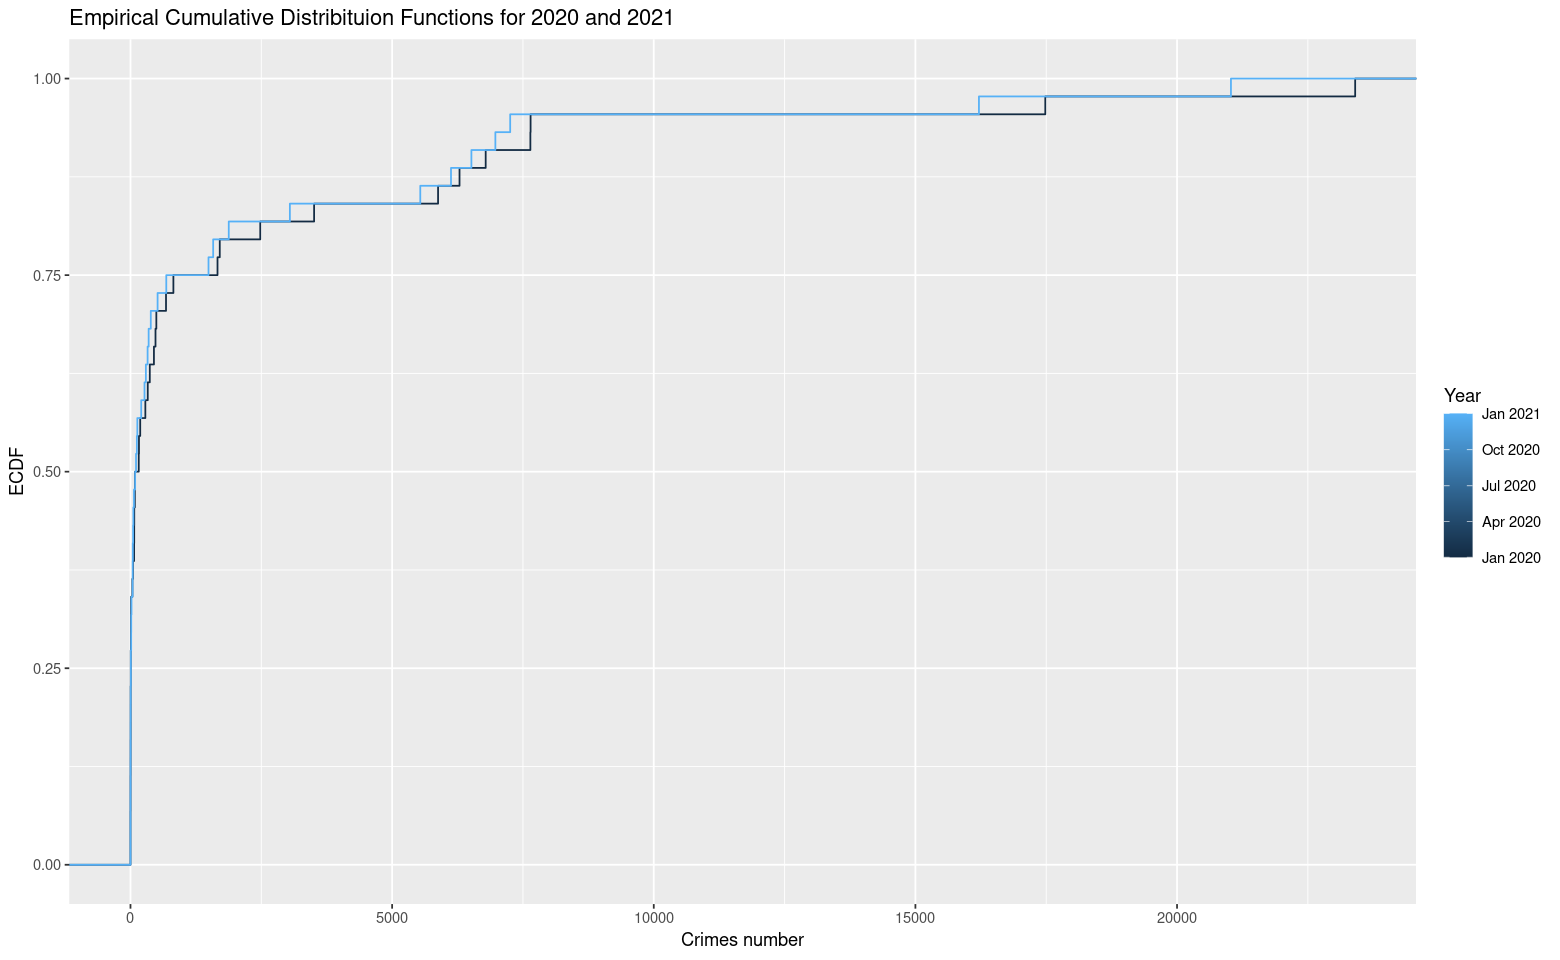

In [30]:
options(repr.plot.width=13, repr.plot.height=8) # Regulates the size of a plot
ggplot(data_total_crimes, aes(x=values, group=date, color=date)) +
  stat_ecdf(geom='step') +
  labs(title='Empirical Cumulative Distribituion Functions for 2020 and 2021',
       x='Crimes number',
       y='ECDF',
       color='Year')  # TODO: vertical lines and gradient removal (mb)

In [31]:
ks.test(values ~ date, data=data_total_crimes)


	Exact two-sample Kolmogorov-Smirnov test

data:  values by date
D = 0.090909, p-value = 0.9909
alternative hypothesis: two-sided


P-value is much higher that the $\alpha$, thus we cannot reject null hypothesis.

Visually we see, that both empirical distribution functions are almost identical, which supporst

### Test #2 (2008 vs 2019)

#### Intuition

This part will examine whether there is a relationship between the number of crimes and time. First, let us consider the intuition why such a test might have meaning.

For this task, we will choose capital region data between $2008$ and $2019$. The regional division was changed after $2019$, so we cannot consider the more recent data along with the older ones, which is simply a larger number. Additionally, in this case, it makes sense to consider absolute values, since this is the same region and its population has not changed much over this period of time.

In [32]:
crime_dynamics <- subset(dataset,
                         geo == 'NO011' & unit == 'NR',
                         c(iccs, TIME_PERIOD, values))
crime_dynamics <- pivot_wider(crime_dynamics, names_from=iccs, values_from=values)
crime_dynamics$ICCS0502 <- crime_dynamics$ICCS0502 - crime_dynamics$ICCS050211  # solution of the same problem with subset
all(colnames(crime_dynamics)[-1] == prev_labels)  # justification for the following line of code
colnames(crime_dynamics)[-1] <- new_labels

[1] TRUE

In [33]:
crime_dynamics

TIME_PERIOD,Int. homicide,Robbery,Other theft,Vehicle theft
<date>,<dbl>,<dbl>,<dbl>,<dbl>
2008-01-01,12,928,39529,2506
2009-01-01,7,1048,41836,2527
2010-01-01,5,958,40755,2161
2011-01-01,19,932,43665,1967
2012-01-01,8,842,47997,1436
2013-01-01,8,961,40261,1254
2014-01-01,7,524,32200,1094
2015-01-01,12,437,28183,895
2016-01-01,4,364,25167,759


As can be seen from the dataframe above there is a downward trend in crime. The following visualization demonstrates this better.

Warning message:
“Using an external vector in selections was deprecated in tidyselect 1.1.0.
ℹ Please use `all_of()` or `any_of()` instead.
  # Was:
  data %>% select(new_labels)

  # Now:
  data %>% select(all_of(new_labels))

See <https://tidyselect.r-lib.org/reference/faq-external-vector.html>.”


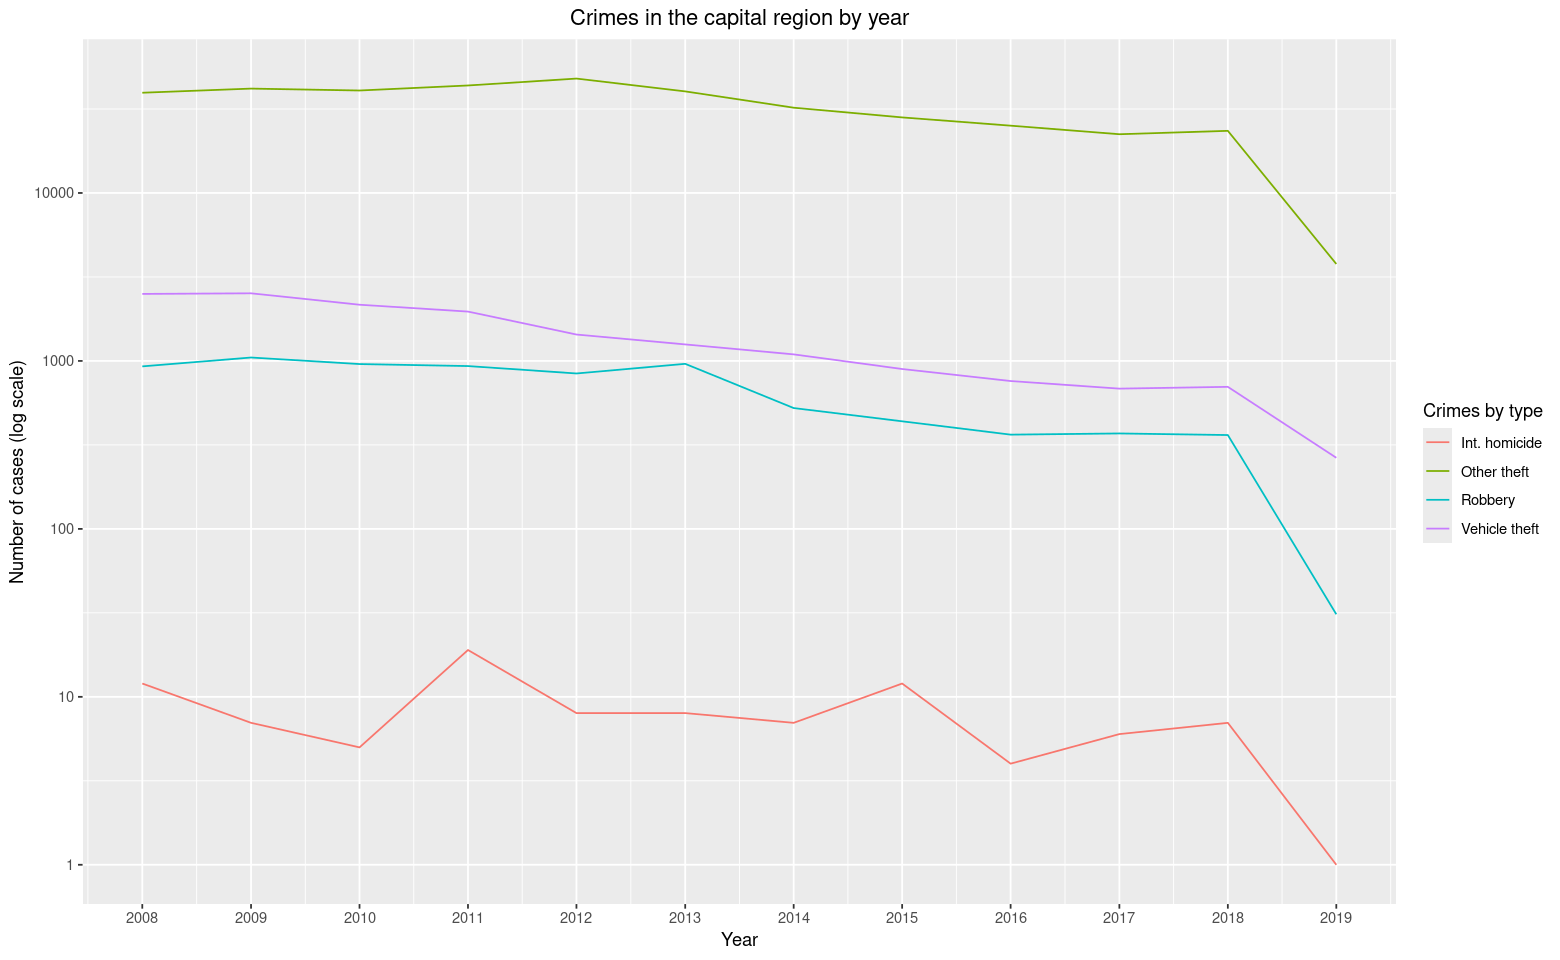

In [34]:
options(repr.plot.width=13, repr.plot.height=8)
ggplot(crime_dynamics %>% pivot_longer(cols=new_labels,
                                       names_to='crime',
                                       values_to='values'),
       aes(x=TIME_PERIOD, y=values, color=crime)) +
    geom_line() +
    scale_x_date(breaks=crime_dynamics$TIME_PERIOD, date_labels='%Y') +
    scale_y_continuous(trans='log10') +
    labs(title='Crimes in the capital region by year',
         x='Year',
         y='Number of cases (log scale)',
         color='Crimes by type') +
    theme(plot.title=element_text(hjust=0.5))

Special attention should be paid to the fact that the y-axis has log scaling. The changes over time are actually impressive. This is confirmed by further examination of $2008$ and $2019$ separately.

In [35]:
freq_time_vs_crime_df <- subset(crime_dynamics, TIME_PERIOD %in% c('2008-01-01', '2019-01-01'))
freq_time_vs_crime_table <- (freq_time_vs_crime_df %>% column_to_rownames('TIME_PERIOD') %>% as.matrix() %>% as.table())
names(dimnames(freq_time_vs_crime_table)) <- c('year', 'crime')

In [36]:
dark_grey <- '#555555'

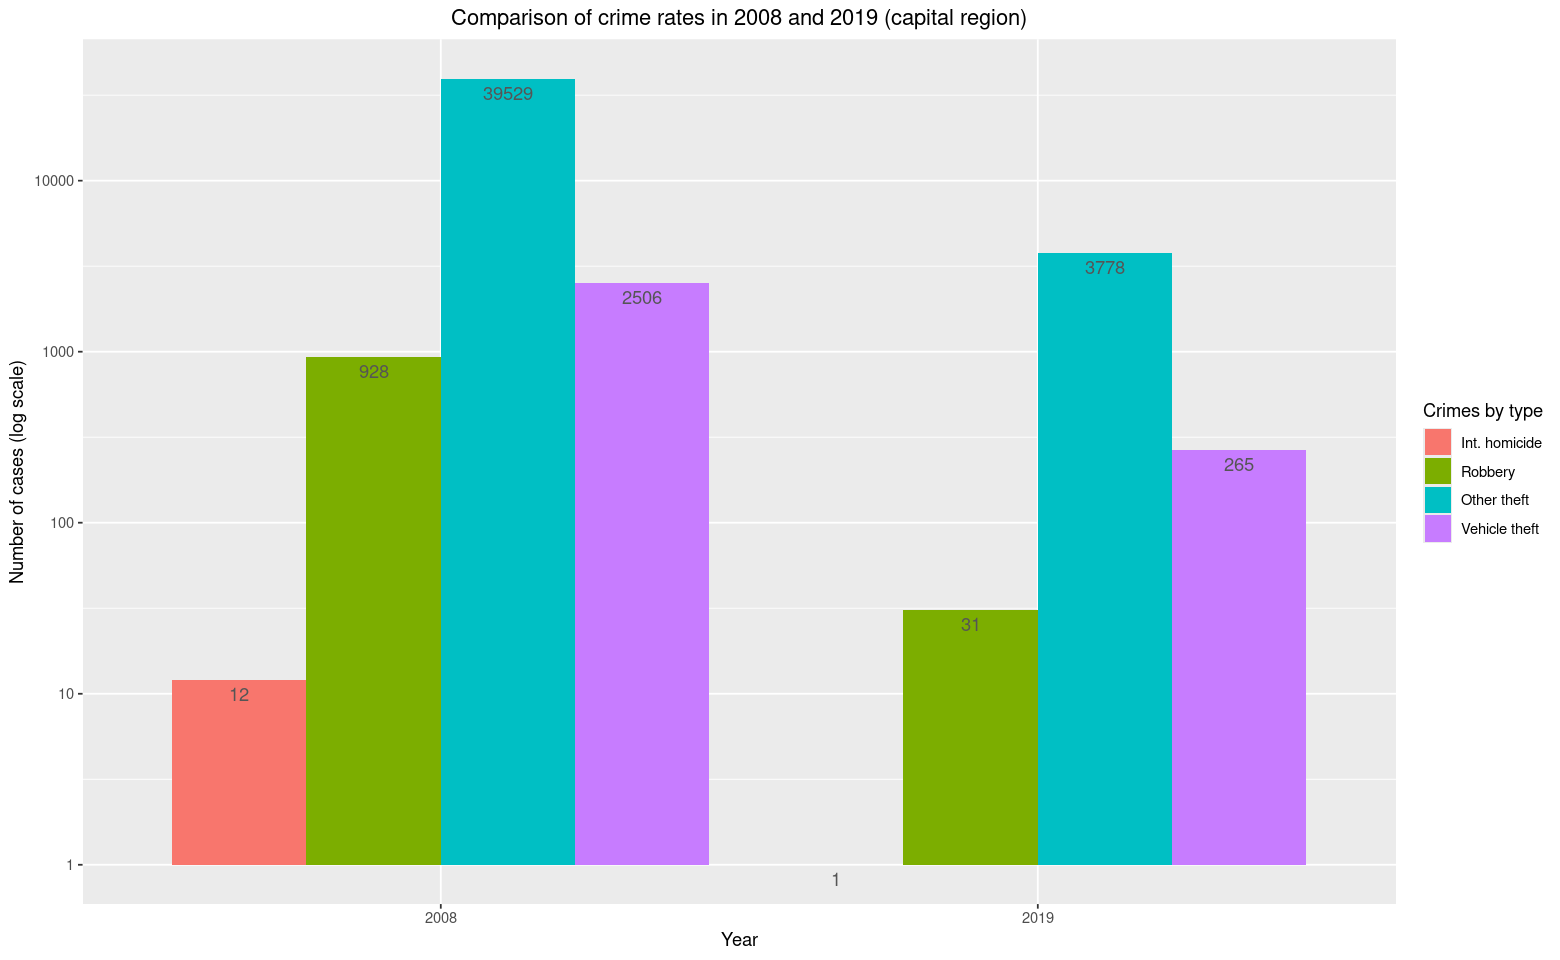

In [37]:
ggplot(as.data.frame(freq_time_vs_crime_table), aes(x=year, y=Freq, fill=crime)) +
    geom_bar(stat='identity', position='dodge') +
    scale_x_discrete(labels=format(freq_time_vs_crime_df$TIME_PERIOD, '%Y')) +
    scale_y_continuous(trans='log10') +
    labs(title='Comparison of crime rates in 2008 and 2019 (capital region)',
         x='Year',
         y='Number of cases (log scale)',
         fill='Crimes by type') +
    theme(plot.title=element_text(hjust=0.5)) +
    geom_text(aes(label=Freq), position=position_dodge(.9), vjust=1.5, color=dark_grey)

The number of cases has decreased by times. Let's check the statistical significance of these changes.

#### Statistical significance

In this instance, the existence of independence between the two variables **year** and **crime** is investigated. Both are qualitative, so it makes sense to look at the contingency table `freq_time_vs_crime_table` to select a statistical test.

In [38]:
freq_time_vs_crime_table

            crime
year         Int. homicide Robbery Other theft Vehicle theft
  2008-01-01            12     928       39529          2506
  2019-01-01             1      31        3778           265

In [39]:
sum(freq_time_vs_crime_table)  # N

[1] 47050

Let's start by defining the matrix of **observed** frequencies $\mathbf O \in \mathbb N^{2,4}$ (`freq_time_vs_crime_table`) and the matrix of **expected** frequencies $\mathbf E \in \mathbb N^{2,4}$ as follows$$(\forall i \in \hat n)(\forall j \in \hat m)\left(\mathbf E_{ij} = \frac{f_{i\cdot} \cdot f_{\cdot j}}{N}\right),$$where $n=2, m=4$ and the expression on the right denotes dividing the **marginal frequencies** by the total number of observations. For example$$\begin{align*}\mathbf E_
{21} = \frac{f_{2\cdot} \cdot f_{\cdot 1}}{N} = \frac{4075 \cdot 13}{47050} \approx 1.126 < 5 && (*)\end{align*}$$

The hypotheses will look as follows$$\begin{align*} H_0: \ \mathbf O = \mathbf E  && \text{(variables are independent)} \\ H_A: \ \mathbf O \ne \mathbf E \end{align*}$$

*Because of this inequality Pearson's chi-squared test cannot be applied on this data, we use Fisher's exact test instead.\
**An analog in probabilities can be given to the expressions above.

In [40]:
fisher.test(freq_time_vs_crime_table, alternative='only in the 2x2 case', simulate.p.value=T)


	Fisher's Exact Test for Count Data with simulated p-value (based on
	2000 replicates)

data:  freq_time_vs_crime_table
p-value = 0.0004998
alternative hypothesis: only in the 2x2 case


Fisher's test uses a hypergeometric distribution to accurately calculate the probability of obtaining such data conditional on $H_0$ being true. In our case, this probability is $0.0005$, which is less than the accepted significance level of $0.05$. This means that we reject the null hypothesis in favor of the alternative.

## Test #3 (Norway vs Finland)

### Intuition

Let's examine the difference in crime rates between Norway and Finland for $2021.$ This can be done on the basis of absolute values, since the populations of these countries are almost equal — $5.408$ million for [Norway](https://www.google.com/search?q=norway+population+2021&sca_esv=6dba56f94bcc106c&sca_upv=1&sxsrf=ACQVn09RNlOaFd8FlhssUGT3EgBV155UgA%3A1711713537425&ei=Aa0GZuK_Gf7bi-gP9Nm6oAI&ved=0ahUKEwiixOvqtZmFAxX-7QIHHfSsDiQQ4dUDCBA&uact=5&oq=norway+population+2021&gs_lp=Egxnd3Mtd2l6LXNlcnAiFm5vcndheSBwb3B1bGF0aW9uIDIwMjEyCBAAGAcYHhgKMgYQABgHGB4yBhAAGAUYHjIGEAAYCBgeMgYQABgIGB5IxxdQwAlYkBZwA3gBkAEAmAFPoAHpA6oBATe4AQPIAQD4AQGYAgqgApUEwgIKEAAYRxjWBBiwA8ICDRAAGIAEGIoFGEMYsAPCAggQABgIGAcYHsICCBAAGAUYBxgewgILEAAYgAQYigUYhgPCAgUQABiABJgDAIgGAZAGCpIHAjEwoAePIw&sclient=gws-wiz-serp) and $5.541$ million for [Finland](https://www.google.com/search?q=finland+population+2021&sca_esv=6dba56f94bcc106c&sca_upv=1&sxsrf=ACQVn09kzkR_WVOdaUguEGXsF7Zm_6H58A%3A1711713567653&ei=H60GZrbAJ6Lbi-gPhvioyAo&ved=0ahUKEwj2y6D5tZmFAxWi7QIHHQY8CqkQ4dUDCBA&uact=5&oq=finland+population+2021&gs_lp=Egxnd3Mtd2l6LXNlcnAiF2ZpbmxhbmQgcG9wdWxhdGlvbiAyMDIxMg8QIxiABBiKBRgnGEYY-wEyBhAAGAgYHjIZEAAYgAQYigUYRhj7ARiXBRiMBRjdBNgBAUieFFD2B1juDnACeAGQAQCYAbUBoAGpBaoBAzYuMbgBA8gBAPgBAZgCCKACqgTCAgoQABhHGNYEGLADwgINEAAYgAQYigUYQxiwA8ICBhAAGAcYHsICCBAAGAgYBxgewgIIEAAYBRgHGB7CAgwQIxiwAhgnGEYY-wHCAhYQABiwAhhGGPsBGJcFGIwFGN0E2AEBmAMAiAYBkAYKugYGCAEQARgTkgcBOKAHkSU&sclient=gws-wiz-serp).

We will look at three categories of crimes and will not include theft of a motor vehicle separately, as these data are not available for Finland.

In [41]:
freq_no_vs_fi_crime_df <- subset(dataset,
                                 geo %in% c('NO', 'FI') &
                                 iccs %in% prev_labels[-4] &
                                 TIME_PERIOD == '2021-01-01' &
                                 unit == 'NR',
                                 c(geo, iccs, values))
freq_no_vs_fi_crime_df <- pivot_wider(freq_no_vs_fi_crime_df, names_from=iccs, values_from=values)
colnames(freq_no_vs_fi_crime_df)[-1] <- c('Int. homicide', 'Robbery', 'Theft')

In [42]:
freq_no_vs_fi_crime_table <- (freq_no_vs_fi_crime_df %>% column_to_rownames('geo') %>% as.matrix() %>% as.table())
names(dimnames(freq_no_vs_fi_crime_table)) <- c('country', 'crime')

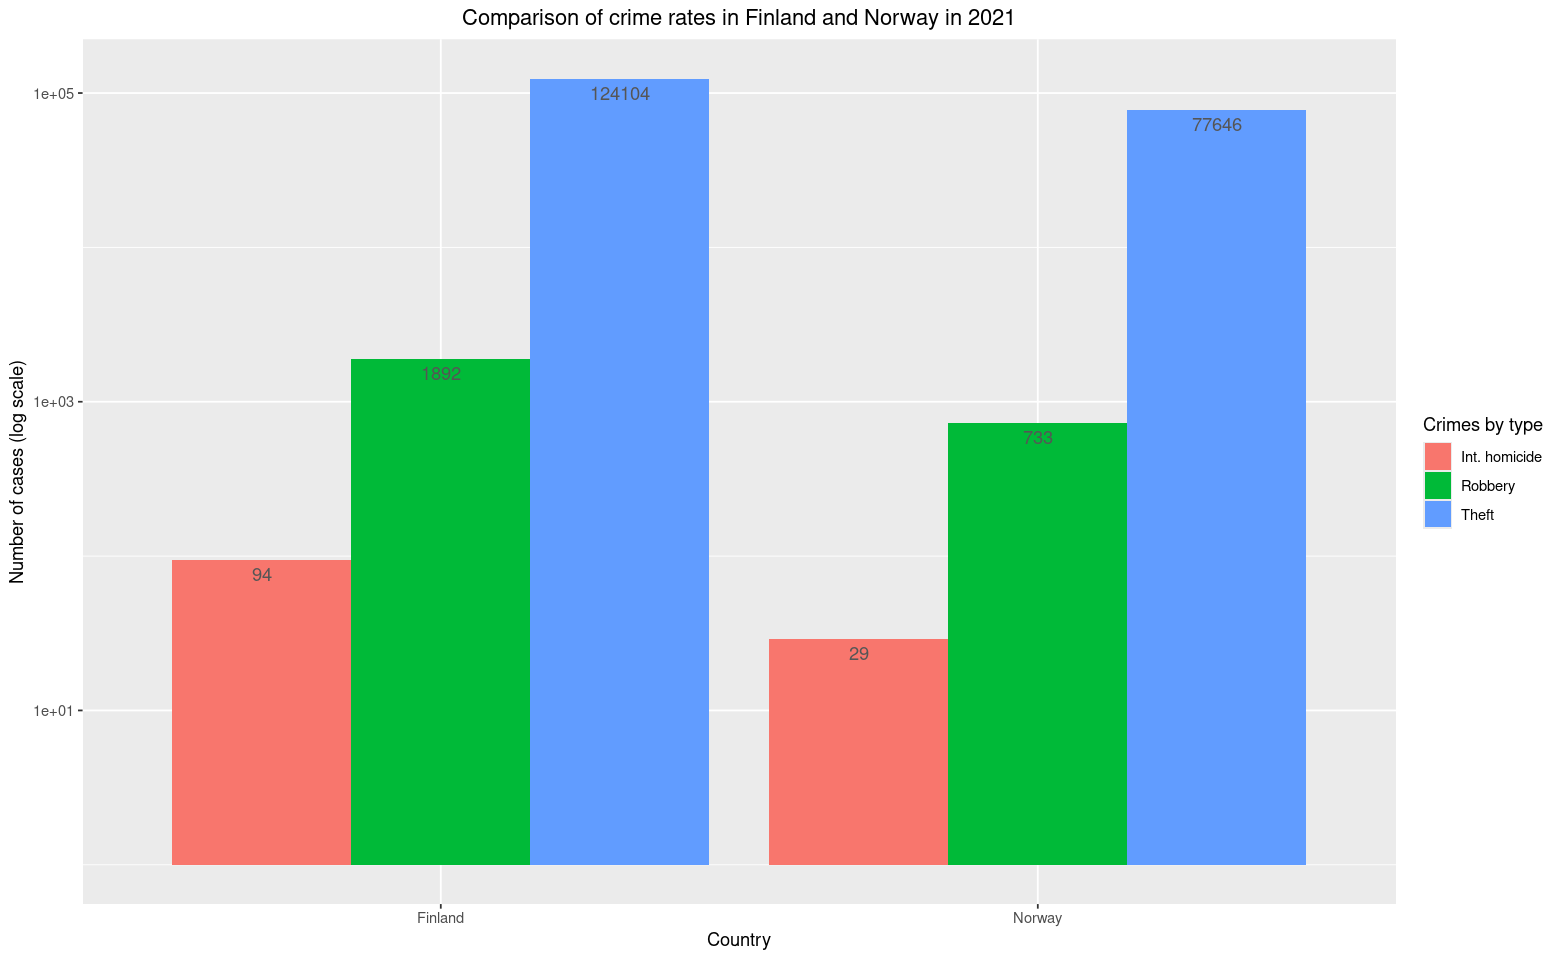

In [43]:
ggplot(as.data.frame(freq_no_vs_fi_crime_table), aes(x=country, y=Freq, fill=crime)) +
    geom_bar(stat='identity', position='dodge') +
    scale_x_discrete(labels=c('Finland', 'Norway')) +
    scale_y_continuous(trans='log10') +
    labs(title='Comparison of crime rates in Finland and Norway in 2021',
         x='Country',
         y='Number of cases (log scale)',
         fill='Crimes by type') +
    theme(plot.title = element_text(hjust=0.5)) +
    geom_text(aes(label=Freq), position=position_dodge(.9), vjust=1.5, color=dark_grey)

There is a big difference in the crime rate in these two countries. Let's check this statistically.

### Statistical significance

The hypotheses will be the same as in the last test$$\begin{align*} H_0: \ \mathbf O = \mathbf E  && \text{(variables are independent)} \\ H_A: \ \mathbf O \ne \mathbf E \end{align*}$$The only difference is that the data will change — $\mathbf O, \mathbf E \in \mathbb N^{2,3}.$ In addition, we can now apply Pearson's chi-squared test since all elements of matrix $\mathbf E$ are greater than or equal to $5$.

In [44]:
freq_no_vs_fi_crime_table

       crime
country Int. homicide Robbery  Theft
     FI            94    1892 124104
     NO            29     733  77646

In [45]:
test_output <- chisq.test(freq_no_vs_fi_crime_table)
round(test_output$expected, digits=2)

,Int. homicide,Robbery,Theft
FI,75.84,1618.53,124395.63
NO,47.16,1006.47,77354.37


In [46]:
test_output


	Pearson's Chi-squared test

data:  freq_no_vs_fi_crime_table
X-squared = 133.64, df = 2, p-value < 2.2e-16


The p-value allows us to reject the null hypothesis in favor of the alternative. This means that the difference in crime between the two countries is statistically significant.

## References

1. ***Eurostat, Column description is located in 'About this dataset' section,*** https://ec.europa.eu/eurostat/databrowser/view/crim_gen_reg/default/table?lang=en&category=crim.crim_off
2. ***Eurostat, Dataset metadata (Completeness section)***, https://ec.europa.eu/eurostat/cache/metadata/en/crim_gen_reg_esms.htm
3. ***Eurostat, Dataset metadata (Unit of measure section)***, https://ec.europa.eu/eurostat/cache/metadata/en/crim_gen_reg_esms.htm
4. ***Eurostat, International classification od crime (codes)***, https://ec.europa.eu/eurostat/databrowser/view/crim_gen_reg/default/table?lang=en&category=crim.crim_off
5. ***Revolutions, Regulation of the size of a plot***, https://blog.revolutionanalytics.com/2015/09/resizing-plots-in-the-r-kernel-for-jupyter-notebooks.html
6. ***EU guidelines for the International Classification of Crime for Statistical Purposes — ICCS***, https://ec.europa.eu/eurostat/documents/3859598/8305054/KS-GQ-17-010-EN-N.pdf/feefb266-becc-441c-8283-3f9f74b29156?t=1507884966000